In [1]:
# Tests for methods that merge horizons
import os
import sys
import warnings
import math
import numpy as np

warnings.filterwarnings('ignore')

sys.path.insert(0, '../..')

from seismiqb import Field, Horizon, plot

In [2]:
""" You can manage cube and horizon for the test:

CUBE_PATH : str
    Path to an existed seismic cube.
HORIZON_PATH : str
    Path to an existed seismic horizon.
"""
# Tests parameters
OUTPUT_DIR = './horizon_test_files'

CUBE_PATH = os.path.join(OUTPUT_DIR, 'test_cube.sgy')
HORIZON_PATH = os.path.join(OUTPUT_DIR, 'test_horizon')

# Visualization parameters
SCALE = 1
SHOW_FIGURES = True

# Output parameters
VERBOSE = True

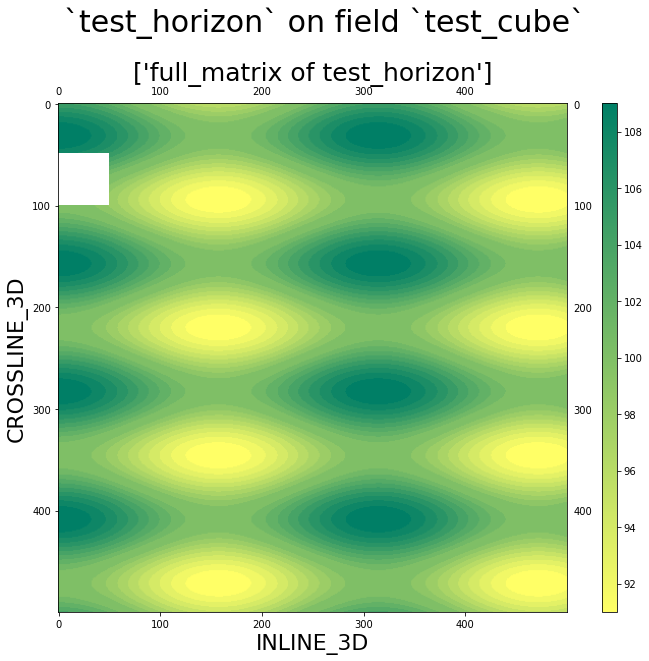

CPU times: user 1.42 s, sys: 5.43 s, total: 6.85 s
Wall time: 941 ms


In [3]:
%%time
field = Field(CUBE_PATH)

horizon = Horizon(HORIZON_PATH, field=field)
horizon.filter()
field.load_labels({'horizons': horizon})

horizon.show(show=SHOW_FIGURES)

message = ""

# Merge two horizons

In [4]:
configs = [
#   (first horizon border, second horizon border, verify_merge code)
    (len(horizon.points)//2, len(horizon.points)//2-len(horizon.points)//10, 4),        # overlapped
    (len(horizon.points)//10, len(horizon.points)//10, 3),                              # close without overlap
    (len(horizon.points)//10, len(horizon.points)//2, 1),                               # spatially far
    (len(horizon.points)//10, len(horizon.points)//10-len(horizon.points)//20, 0)       # for height-wise far
]

In [5]:
%%time
# Horizon.*_merge methods

for (border_1, border_2, code) in configs:
    # Create new horizons
    horizon_1 = Horizon(horizon.points[:border_1, :], field=field, name='horizon_1')
    horizon_2 = Horizon(horizon.points[border_2:, :], field=field, name='horizon_2')

    if code == 0: # Make horizons height-wise far
        horizon_2.points[:, 2] += 50

    # Check merge code
    verified_code = horizon_1.verify_merge(horizon_2, adjacency=1)
    error_message = f"Merge two horizons with code {code} test failed: verified code {verified_code} wasn't expected"
    assert verified_code == code, error_message

    # Merge and check horizons if they are mergeable
    if code == 4:
        merged_horizon = Horizon.overlap_merge(horizon_1, horizon_2)

        assert horizon.equal(merged_horizon), "Overlapped horizons merge failed: merged horizon unequals to original one"

    elif code == 3:
        merged_horizon = horizon_1.adjacent_merge(horizon_2)

        assert horizon.equal(merged_horizon), "Close horizons merge failed: merged horizon unequals to original one"

    if VERBOSE:
        current_message = f"The two horizons merge test with merge code {code} was successfully passed.\n"
        print(current_message)
        message += current_message

The two horizons merge test with merge code 4 was successfully passed.

The two horizons merge test with merge code 3 was successfully passed.

The two horizons merge test with merge code 1 was successfully passed.

The two horizons merge test with merge code 0 was successfully passed.

CPU times: user 335 ms, sys: 4.89 ms, total: 340 ms
Wall time: 340 ms


# Merge multiple horizons

We split a horizon in multiple parts, merge them into one horizon and compare it with original one.

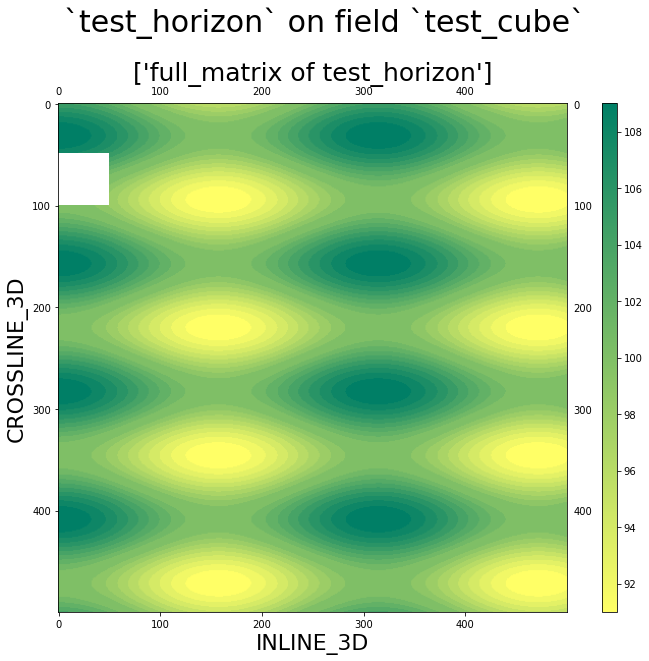

In [6]:
# Create new horizon with much more empty traces
zero_traces = np.tril(horizon.full_matrix).astype(bool)
horizon.filter(zero_traces)
horizon.filter_disconnected_regions()

horizon.show(show=SHOW_FIGURES, scale=SCALE)

In [7]:
def split_and_merge_horizon_test(horizon, crop_shape, overlap, adjacency):
    """ Split a horizon in crops with overlap and merge them.

    Merged horizon compared with the original.

    Parameters
    ----------
    horizon : :class:`Horizon`
        Seismic horizon instance.
    crop_shape : sequence of two integers
        Crop shape (ilines, xlines).
    overlap : sequence of two integers
        Crops overlap by (ilines, xlines).
    adjacency : int
        Margin to consider horizons to be spatially close.
    """
    current_message = ""
    params = f"crop_shape={crop_shape}; overlap={overlap}; adjacency={adjacency}"
    borders = []

    # Get splitting borders
    for axis in range(2):
        stride = crop_shape[axis] - overlap[axis]
        n_crops = math.ceil(horizon.full_matrix.shape[axis] / stride)
        axis_borders = [(i*stride, i*stride + crop_shape[axis]) for i in range(n_crops)]

        borders.append(axis_borders)

    horizons = []

    # Split a horizon
    for i_border_num, horizon_i_borders in enumerate(borders[0]):
        for x_border_num, horizon_x_borders in enumerate(borders[1]):
            cutted_horizon_matrix = horizon.full_matrix[horizon_i_borders[0]:horizon_i_borders[1],
                                                        horizon_x_borders[0]:horizon_x_borders[1]]

            if not np.all(cutted_horizon_matrix == horizon.FILL_VALUE):
                horizon_ = Horizon(cutted_horizon_matrix, force_format='matrix',
                                   i_min=horizon_i_borders[0], x_min=horizon_x_borders[0],
                                   field=field, name=f"A_horizon_{i_border_num*x_border_num}")

                horizons.append(horizon_)

    # Calculate horizons summation for additional checks
    merged_ = np.zeros_like(horizons[0].full_matrix)

    for horizon_ in horizons:
        merged_ += (horizon_.full_matrix > 0)

    # Horizon merge: inplace
    horizons, _ = Horizon.merge_list(horizons, adjacency=adjacency, mean_threshold=5.)
    merged_horizon = horizons[-1]

    # Take a look at horizon parts summation
    if SHOW_FIGURES:
        plot([merged_, merged_horizon.full_matrix], combine='separate',
             scale=SCALE, suptitle_label=params, colorbar=True, fontsize=14)

    # Asserts
    error_message = f"`merge_list` test with params {params} failed"
    if (overlap[0] >= 0) and (overlap[1] >= 0):
        n_missing = 0
        assert horizon.equal(merged_horizon, threshold_missing=n_missing), error_message

    else:
        n_missing = len(horizon) - (merged_ > 0).sum()
        assert horizon.equal(merged_horizon, threshold_missing=n_missing + 1), error_message

    if VERBOSE:
        current_message = f"`merge_list` test with params {params} was successfully passed"
        print(current_message)
        
    return current_message

In [8]:
overlaps = [(i, j) for i in range(-3, 4) for j in range(-3, 4)]

SHOW_FIGURES = False

crop_shapes = [
    (horizon.full_matrix.shape[0]//20+1, horizon.full_matrix.shape[1]//20+1),   # Split horizon into small square crops
    (horizon.full_matrix.shape[0]//10+1, horizon.full_matrix.shape[1]//10+1),   # Split horizon into medium square crops
    (horizon.full_matrix.shape[0]//5+1, horizon.full_matrix.shape[1]//5+1),     # Split horizon into big square crops
    (horizon.full_matrix.shape[0], horizon.full_matrix.shape[1]//20+1),         # Split horizon by i_lines
    (horizon.full_matrix.shape[0]//20+1, horizon.full_matrix.shape[1])          # Split horizon by x_lines
]

for crop_shape in crop_shapes:
    for overlap in overlaps:
        min_ = min(overlap)
        adjacency = 0 if min_ > 0 else -min_ + 1
        message += split_and_merge_horizon_test(horizon=horizon, crop_shape=crop_shape, overlap=overlap, adjacency=adjacency)

`merge_list` test with params crop_shape=(26, 26); overlap=(-3, -3); adjacency=4 was successfully passed

`merge_list` test with params crop_shape=(26, 26); overlap=(-3, -2); adjacency=4 was successfully passed

`merge_list` test with params crop_shape=(26, 26); overlap=(-3, -1); adjacency=4 was successfully passed

`merge_list` test with params crop_shape=(26, 26); overlap=(-3, 0); adjacency=4 was successfully passed

`merge_list` test with params crop_shape=(26, 26); overlap=(-3, 1); adjacency=4 was successfully passed

`merge_list` test with params crop_shape=(26, 26); overlap=(-3, 2); adjacency=4 was successfully passed

`merge_list` test with params crop_shape=(26, 26); overlap=(-3, 3); adjacency=4 was successfully passed

`merge_list` test with params crop_shape=(26, 26); overlap=(-2, -3); adjacency=4 was successfully passed

`merge_list` test with params crop_shape=(26, 26); overlap=(-2, -2); adjacency=3 was successfully passed

`merge_list` test with params crop_shape=(26, 26);

# Extract

In [9]:
%%time
valid_traces = field.dead_traces_matrix == 0

mask = np.zeros(field.shape, dtype=np.int32)
for horizon in field.labels:
    mask[horizon.points[:, 0], horizon.points[:, 1], horizon.points[:, 2]] = 1

origin = np.array([0, 0, 0])

CPU times: user 38.9 ms, sys: 27.3 ms, total: 66.3 ms
Wall time: 64.3 ms


## No chunks

In [12]:
horizons = Horizon.from_mask(mask.copy(), field=field, origin=origin)
extracted_horizon = horizons[-1]

assert horizon.equal(extracted_horizon), "`from_mask` test failed: original and extracted horizons are unequal"

## With chunks

In [13]:
def chunked_extraction_test(mask, true_horizon, valid_traces, origin, step, overlap):
    """ Split a horizon in chunks using mask and merge them.

    Merged horizon compared with the original.

    Parameters
    ----------
    mask : np.ndarray
        Horizon presence mask in the cube coordinates. 
    true_horizon : :class:`Horizon`
        Seismic horizon instance.
    valid_traces : np.ndarray
        Mask of valid traces in the field.
    origin : sequence of three integers
        The upper left coordinate of a `mask` in the cube coordinates.
    step : int
        Chunk size along i_lines and x_lines.
    overlap : sequence of two integers
        Crops overlap by (ilines, xlines).
    """
    current_message = ""
    params = f"step={step}; overlap={overlap}"
    i_step = x_step = step
    i_stride = x_stride = step - overlap

    # Create horizons from subvolumes
    horizons = []
    for i_start in range(0, mask.shape[0], i_stride):
        for x_start in range(0, mask.shape[1], x_stride):
            i_end = min(i_start + i_step, mask.shape[0])
            x_end = min(x_start + x_step, mask.shape[1])

            slices = (slice(i_start, i_end), slice(x_start, x_end), slice(None))

            if valid_traces[slices[:2]].sum() > 0:
                subvolume = mask[slices].copy()
                subvolume_origin = origin + [slc.start or 0 for slc in slices]

                horizons_, _ = Horizon.extract_from_mask(subvolume, field=field, origin=subvolume_origin,
                                                         minsize=0, verbose=False)
                horizons.extend(horizons_)

    # Merge horizons from chunks
    horizons, _ = Horizon.merge_list(horizons, mean_threshold=0.5, max_threshold=0.2, adjacency=0)
    extracted_horizon = horizons[-1]

    assert true_horizon.equal(extracted_horizon), f"Extraction with chunks test failed with params: {params}"

    if VERBOSE:
        current_message = f"The extraction with chunks test with params {params} was successfully passed.\n"
        print(current_message)

    return current_message

In [14]:
for step in [30, 50, 100]:
    for overlap in [5, 10, 15]:
        message += chunked_extraction_test(mask.copy(), true_horizon=horizon,
                                           valid_traces=valid_traces, origin=origin,
                                           step=step, overlap=overlap)

The extraction with chunks test with params step=30; overlap=5 was successfully passed.

The extraction with chunks test with params step=30; overlap=10 was successfully passed.

The extraction with chunks test with params step=30; overlap=15 was successfully passed.

The extraction with chunks test with params step=50; overlap=5 was successfully passed.

The extraction with chunks test with params step=50; overlap=10 was successfully passed.

The extraction with chunks test with params step=50; overlap=15 was successfully passed.

The extraction with chunks test with params step=100; overlap=5 was successfully passed.

The extraction with chunks test with params step=100; overlap=10 was successfully passed.

The extraction with chunks test with params step=100; overlap=15 was successfully passed.

